In [1]:
import pandas as pd
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

# Data Processing 
import os
import os.path
import random
import PIL
import glob
from PIL import Image # to read images

Use Keras Model Architecture

In [40]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

In [43]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Dataset Preparation

In [10]:
path = "/content/drive/My Drive/"
anns_file_path = "/content/drive/My Drive/annotations.json"

In [11]:
# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [12]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [13]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [14]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [15]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


In [16]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [17]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [18]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min'] 
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)

Add padding to the bounding boxes

In [19]:
padding = 20

In [20]:
df['x_min'] = df['x_min'] - padding
df['y_min'] = df['y_min'] - padding
df['x_max'] = df['x_max'] + padding
df['y_max'] = df['y_max'] + padding

In [21]:
df.head()

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000006.jpg,Glass bottle,497,107,984,1469
1,batch_1/000012.jpg,Glass bottle,359,1107,824,1465
2,batch_1/000048.jpg,Glass bottle,191,-19,648,1438
3,batch_1/000021.jpg,Glass bottle,832,618,1559,949
4,batch_1/000022.jpg,Glass bottle,627,1013,1487,1429


Fetch the images and crop it using bbox

In [22]:
train_data = []  
for ind in df.index:
    bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
    img=Image.open(os.path.join(path+'data/'+df['filename'][ind]))
    img=img.crop(bbox)
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = image.img_to_array(img)
    # Save image
    train_data.append(img)

In [23]:
X = np.array(train_data)
print(X.shape)

(1442, 128, 128, 3)


In [24]:
# Create dummy variables
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)
df = pd.get_dummies(df, columns=["category"])
df.head()

,filename,category_Cigarette,category_Clear plastic bottle,category_Drink can,category_Glass bottle,category_Plastic straw
0,batch_1/000006.jpg,0,0,0,1,0
1,batch_1/000012.jpg,0,0,0,1,0
2,batch_1/000048.jpg,0,0,0,1,0
3,batch_1/000021.jpg,0,0,0,1,0
4,batch_1/000022.jpg,0,0,0,1,0


Drop filename Convert image data into numpy array to get y

In [25]:
y = np.array(df.drop(['filename'],axis=1))

In [26]:
print(y.shape)
print(X.shape)

(1442, 5)
(1442, 128, 128, 3)


In [27]:
# Data split Randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [28]:
#X_train1 = tf.convert_to_tensor(X_train)
#y_train1 = tf.convert_to_tensor(y_train)

Build Keras Model

In [29]:
keras_model = Sequential()
keras_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
keras_model.add(MaxPooling2D(pool_size=(2, 2)))
keras_model.add(BatchNormalization())
#
keras_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
keras_model.add(MaxPooling2D(pool_size=(2, 2)))
keras_model.add(BatchNormalization())
keras_model.add(Dropout(0.5))
#
keras_model.add(Flatten())
keras_model.add(Dense(128, activation='relu'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(5, activation='softmax'))

keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0

In [30]:
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
early_stopper = EarlyStopping(monitor = 'val_loss', patience = 50)

In [32]:
# Model fit
history = keras_model.fit(X_train, y_train, epochs=100, batch_size=50, validation_split=0.20, callbacks = [early_stopper])

Epoch 1/100
19/19 [==============================] - 21s 1s/step - loss: 9.5848 - accuracy: 0.4306 - val_loss: 18.8971 - val_accuracy: 0.4892
Epoch 2/100
19/19 [==============================] - 21s 1s/step - loss: 4.2680 - accuracy: 0.6226 - val_loss: 30.5663 - val_accuracy: 0.2294
Epoch 3/100
19/19 [==============================] - 21s 1s/step - loss: 2.3776 - accuracy: 0.7299 - val_loss: 15.1862 - val_accuracy: 0.4459
Epoch 4/100
19/19 [==============================] - 21s 1s/step - loss: 1.7198 - accuracy: 0.7972 - val_loss: 11.0005 - val_accuracy: 0.6104
Epoch 5/100
19/19 [==============================] - 21s 1s/step - loss: 1.1890 - accuracy: 0.7928 - val_loss: 9.3176 - val_accuracy: 0.6277
Epoch 6/100
19/19 [==============================] - 21s 1s/step - loss: 0.9000 - accuracy: 0.8514 - val_loss: 7.1146 - val_accuracy: 0.6364
Epoch 7/100
19/19 [==============================] - 21s 1s/step - loss: 0.6405 - accuracy: 0.8590 - val_loss: 8.3371 - val_accuracy: 0.6061
Epoch 8/1

In [33]:
# evaluate the model
_, train_acc = keras_model.evaluate(X_train, y_train)
_, test_acc = keras_model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

10/10 [==============================] - 2s 157ms/step - loss: 4.9392 - accuracy: 0.6886
Train: 0.936, Test: 0.689


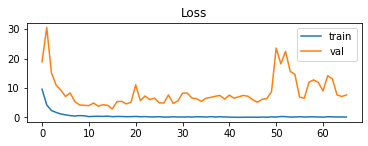

In [34]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()

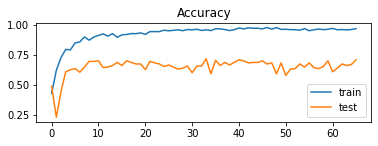

In [35]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Prevention of overfitting Model

1. Reduce the number of input/output layers and less neurons
2. Stop the model training by reducing early patience to '5'


In [50]:
# New simpler keras model
new_model = Sequential()
new_model.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.5))
#
new_model.add(Flatten())
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(5, activation='softmax'))
print(new_model.summary())
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 63, 63, 16)        64        
_________________________________________________________________
dropout_20 (Dropout)         (None, 63, 63, 16)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 63504)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2032160   
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)              

In [51]:
early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)

In [52]:
# Model fit
history_new_model = new_model.fit(X_train, y_train, epochs=100, batch_size=50, validation_split=0.20, callbacks = [early_stopper])

Epoch 1/100
19/19 [==============================] - 7s 394ms/step - loss: 7.2178 - accuracy: 0.4067 - val_loss: 33.7825 - val_accuracy: 0.1558
Epoch 2/100
19/19 [==============================] - 7s 382ms/step - loss: 3.2813 - accuracy: 0.4957 - val_loss: 10.4247 - val_accuracy: 0.5368
Epoch 3/100
19/19 [==============================] - 8s 402ms/step - loss: 1.9980 - accuracy: 0.5466 - val_loss: 3.4192 - val_accuracy: 0.5455
Epoch 4/100
19/19 [==============================] - 7s 378ms/step - loss: 1.6006 - accuracy: 0.5900 - val_loss: 1.7137 - val_accuracy: 0.5671
Epoch 5/100
19/19 [==============================] - 9s 496ms/step - loss: 1.2512 - accuracy: 0.6236 - val_loss: 1.6608 - val_accuracy: 0.5887
Epoch 6/100
19/19 [==============================] - 7s 378ms/step - loss: 1.1993 - accuracy: 0.6204 - val_loss: 1.9997 - val_accuracy: 0.6017
Epoch 7/100
19/19 [==============================] - 7s 375ms/step - loss: 1.0570 - accuracy: 0.6117 - val_loss: 2.0002 - val_accuracy: 0.59

In [53]:
# evaluate the model
_, train_acc = new_model.evaluate(X_train, y_train)
_, test_acc = new_model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

10/10 [==============================] - 1s 73ms/step - loss: 1.5668 - accuracy: 0.6228
Train: 0.768, Test: 0.623


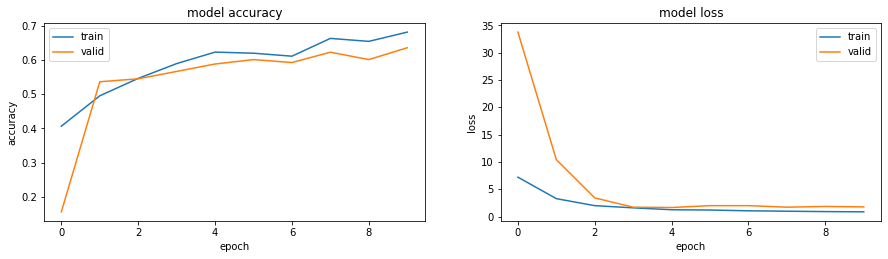

In [70]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history_new_model.history['accuracy'])  
plt.plot(history_new_model.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history_new_model.history['loss'])  
plt.plot(history_new_model.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [85]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

saved_path = path+'saved_model/'
# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = new_model.to_json()


with open("model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
new_model.save_weights("model_num.h5")

Model Prediction

In [86]:
predictions = new_model.predict(x=X_test, steps=len(X_test), verbose=0)
classes = np.array(df.columns[1:])

In [97]:
all_5 = np.argsort(predictions[0])
for i in range(5):
    print("{}".format(classes[all_5[i]])+" ({:.3})".format(predictions[0][all_5[i]]*100))


category_Glass bottle (9.7)
category_Plastic straw (12.6)
category_Drink can (23.2)
category_Clear plastic bottle (23.9)
category_Cigarette (30.6)


**Use K-Fold technique to see overfitting of newly created Model**

In [56]:
def create_model():
  classifier = Sequential()
  classifier.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
  classifier.add(MaxPooling2D(pool_size=(2, 2)))
  classifier.add(BatchNormalization())
  classifier.add(Dropout(0.5))
  #
  classifier.add(Flatten())
  classifier.add(Dense(32, activation='relu'))
  classifier.add(Dropout(0.5))
  classifier.add(Dense(5, activation='softmax'))
  classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return classifier 

In [57]:
model=KerasClassifier(build_fn=create_model, epochs=100, batch_size=50, verbose=1)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results=cross_val_score(model,X_train, y_train,cv=kfold,verbose=10, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 50.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 124.7min finished


In [71]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 63.31% (4.26%)
